# XCLASS: creating images for targets

For Matej Kosiba's neural network training. Workflow to download and save images. There will be 3 images per target coordinates: one optical from DSS22 red band, and two XMM-Newton for two bands.

1. Set the coordinates of the target.
1. Identify the observation id (`OBS_ID`) where the target falls in, using `astroquery.esasky` module.
1. Get XMM-Newton pipeline (PPS) images for the PN in all 4 bands that contain the target. Using NXSA URL access.
1. Combine bands 2+3 and 4+5 to make two X-ray images in the soft band [0.5-2.0] keV and hard band [2.0-12.0] keV.
1. Get the DSS2 Red band image withint the input box size from SkyView using `astroquery.skyview` module.
1. Save the optical image.
1. Crop the X-ray images in the user selected box (usually the same as the optical).
1. Save th ecropped X-ray images
1. In parallel, display the three images in the notebook.

**Note:** the optical and the X-ray cropped images will be saved without any re-normalisation.


In [1]:
import os
import tarfile
import requests
import shutil

import numpy as np

from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy.nddata import Cutout2D

from astropy.coordinates import SkyCoord
from astropy import units as u

from astroquery.skyview import SkyView

%matplotlib inline
import matplotlib.pylab as plt

home = os.path.expanduser('~')
tmpdir = os.path.join(home,"tmp","XMM_data")
if (not os.path.isdir(tmpdir)):
    print ("Please set the tmpdir to an aleady existing folder. It is needed.")
    raise FileNotFoundError
#

## Identify XMM OBS_ID for the point of interest

Will use `astroquery.esasky` to identify the `OBS_ID` where the target coordinates are.

In [2]:
#GCl in the field of 3c234
#ra = "10h01m17.49s"
#dec= "+28d51m11.4s"
# mrk 1040
#ra = "02h28m14.0s"
#dec= "+31d18m42.0s"
# NGC4151
ra = "12h10m32.5s"
dec= "+39d24m20.0s"
c = SkyCoord(ra, dec, frame='icrs')
# box size for the region of interest, the images will be cropped to it.
box = 6.0*u.arcmin

## Using the TAP interface to XSA to find the OBS_ID

In [3]:
radius = 15.0/60.0 # 15 arcmin circle
tap_cat = "v_public_observations"
circle = f"circle('ICRS',{c.ra.value:.4f},{c.dec.value:.4f},{radius})"
dist = f"DISTANCE(POINT('ICRS',t2.ra,t2.dec),POINT('ICRS',{c.ra.value:.4f},{c.dec.value:.4f}))"
# 
print (f"Search in {tap_cat} for observations intersecting with {circle}")
#
tap_url = "http://nxsa.esac.esa.int/tap-server/tap/sync?REQUEST=doQuery&LANG=ADQL&FORMAT=csv&"
# now combine two tables to include the observing mode
# instrument_mode_oid for EPN is from 60 to 69, will only search for those
#
query = f"QUERY=select top 100 t2.observation_id,t2.ra,t2.dec,t2.revolution,t2.duration,t3.mode_friendly_name" +\
    " from v_exposure as t1, v_public_observations as t2, v_instrument_mode as t3" + \
    " WHERE " + \
    "(t1.observation_oid = t2.observation_oid) and " +\
    "(t1.instrument_mode_oid BETWEEN 60 and 69) and " +\
    "(t1.instrument_mode_oid = t3.instrument_mode_oid) and " +\
    f"(1=intersects(observation_fov_scircle,{circle}))"
# this one works
#query = f"QUERY=select top 100 t2.observation_id,t2.ra,t2.dec,t2.revolution,t2.duration,t1.instrument_mode_oid" +\
#    " from v_exposure as t1, v_public_observations as t2" + \
#    " where t1.observation_oid = t2.observation_oid and (t1.instrument_mode_oid BETWEEN 60 and 69)" +\
#    f" and 1=intersects(observation_fov_scircle,{circle})"

#    " where t1.observation_oid = t2.observation_oid and (t1.instrument_mode_oid >= 60 and t1.instrument_mode_oid <= 69)" +\
#query = f"QUERY=SELECT+top+10+ra,dec,observation_id,revolution,duration+FROM+{tap_cat}" +\
#    f"+WHERE+1=intersects(observation_fov_scircle,{circle})"
xreq = tap_url + query
with requests.get(xreq) as r:
    jx = r.content.decode()

Search in v_public_observations for observations intersecting with circle('ICRS',182.6354,39.4056,0.25)


### Convert the TAP output CSV to a table (pandas dataframe)

In [4]:
import pandas as pd
from io import StringIO
buff = StringIO(jx)
df = pd.read_csv(buff, sep=",")
#df

In [5]:
#
# calculate the separation
#
cobs = SkyCoord(df.ra,df.dec,frame='icrs',unit='deg')
sep = cobs.separation(c)
df["offset"] = sep.to(u.arcmin)
obs_table = df.sort_values("offset")
obs_table.rename(columns={'observation_id': 'obs_id','mode_friendly_name': 'obs_mode','revolution': 'rev'},inplace=True)
print (obs_table)
k = 0
xmode = obs_table.iloc[[k]].obs_mode.values[0]
while (not ("Large" in xmode or "Full" in xmode)):
    if (k > len(obs_table)):
        print ("Could not find Full Frame or Large Window mode observations.")
        obsid = None
        break
    obsid = f"{obs_table.iloc[[k]].obs_id.values[0]:010}"
    xmode = obs_table.iloc[[k]].obs_mode.values[0]
    k += 1
#
print (f"*** Will pick up {obs_table.iloc[[k-1]]} as the source is closer to the optical axis.")    

       obs_id          ra        dec   rev  duration             obs_mode  \
9   143500101  182.635800  39.405560   633     18956         Small Window   
10  143500201  182.635800  39.405560   634     18949         Small Window   
11  143500301  182.635800  39.405560   634     18950         Small Window   
30  761670901  182.635708  39.405778  2937     45500         Small Window   
27  761670301  182.635708  39.405778  2919     47000         Small Window   
23  761670201  182.635708  39.405778  2918     46300         Small Window   
28  761670701  182.635708  39.405806  2934     49600         Small Window   
26  761670401  182.635708  39.405806  2926     45000         Small Window   
25  761670501  182.635708  39.405806  2921     41699         Small Window   
24  761670601  182.635708  39.405806  2922     46000         Small Window   
22  761670101  182.635708  39.405806  2917     46300         Small Window   
29  761670801  182.635708  39.405806  2935     45000         Small Window   

### Alternatively we could use astroquery.esasky 

In [6]:
#from astroquery.esasky import ESASky
#result = ESASky.get_images(c, radius='2 arcmin', missions=['XMM'],download_dir=tmpdir)
#obsid = result['XMM'][0][0].header["OBS_ID"]

## Download the tar file from the XMM archive

Once we have the `OBS_ID` then we proceed using [the URL access](http://nxsa.esac.esa.int/nxsa-web/#aio_client) to the XMM-Newton archive.

In [7]:
#ftype = 'SRSPEC0001'
ftype = "IMAGE"
extn = "FTZ"
inst = "PN"
url = 'http://nxsa.esac.esa.int/nxsa-sl/servlet'
#req  = f"{url}/data-action-aio?obsno={iobs}&name={ftype}&level=PPS"
req  = f"{url}/data-action-aio?obsno={obsid}&extension={extn}&name={ftype}&instname={inst}&level=PPS"

tarFile = f"{tmpdir}/pps_{obsid}.tar"

with requests.get(req) as r:
    #r.raise_for_status() # ensure we notice bad responses
    if (b'No results' in r.content):
        print ("No PPS products found for {obsid}")
        raise Exception
    else:
        with open(tarFile,"wb") as tmp:
            tmp.write(r.content)
print (f"{inst} images in all bands saved to {tarFile}")

PN images in all bands saved to /Users/ivaltcha/tmp/XMM_data/pps_0112830201.tar


## Extract the XMM images

Here we extract the images and then co-add the bands to create two images in bands [0.5-2] and [2-12.0] keV. This means co-adding band 2+3 and 4+5.

In [104]:
bands = [2,3,4,5]
maps = {}
with tarfile.open(tarFile,'r') as tar:
    for xband in bands:
        sband = f'{xband}000'
        for member in tar.getmembers():
            if (sband in member.name):
                print (f"Extracting {member.name}")
                f=tar.extract(member,path=tmpdir)
                hdu = fits.open(f"{tmpdir}/{member.name}")
                maps[sband] = hdu[0]
#
# co-adding 
#
sb = maps['2000'].data + maps['3000'].data
hb = maps['4000'].data + maps['5000'].data
hdu_soft = fits.PrimaryHDU(sb)
hdu_soft.header = maps['2000'].header
hdu_hard = fits.PrimaryHDU(hb)
hdu_hard.header = maps['4000'].header

Extracting 0112830201/pps/P0112830201PNS002IMAGE_2000.FTZ
Extracting 0112830201/pps/P0112830201PNS002IMAGE_3000.FTZ
Extracting 0112830201/pps/P0112830201PNS002IMAGE_4000.FTZ
Extracting 0112830201/pps/P0112830201PNS002IMAGE_5000.FTZ


## Download optical images

Will use DSS2 red images available through the `astroquery.SkyView` service. Can be slow! 

In [105]:

paths = SkyView.get_images(c,survey=['DSS2 Red'],width=box,height=box, coordinates="ICRS")

In [106]:
saveToFits = True
output_dir = tmpdir = os.path.join(home,"tmp","XMM_data","outputs")
if ((not os.path.isdir(output_dir)) and saveToFits):
    print ("Please set the output_dir to an aleady existing folder. It is needed.")
    raise FileNotFoundError

In [107]:
paths[0][0].writeto(f"{output_dir}/{obsid}_dss2r.fits",overwrite=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


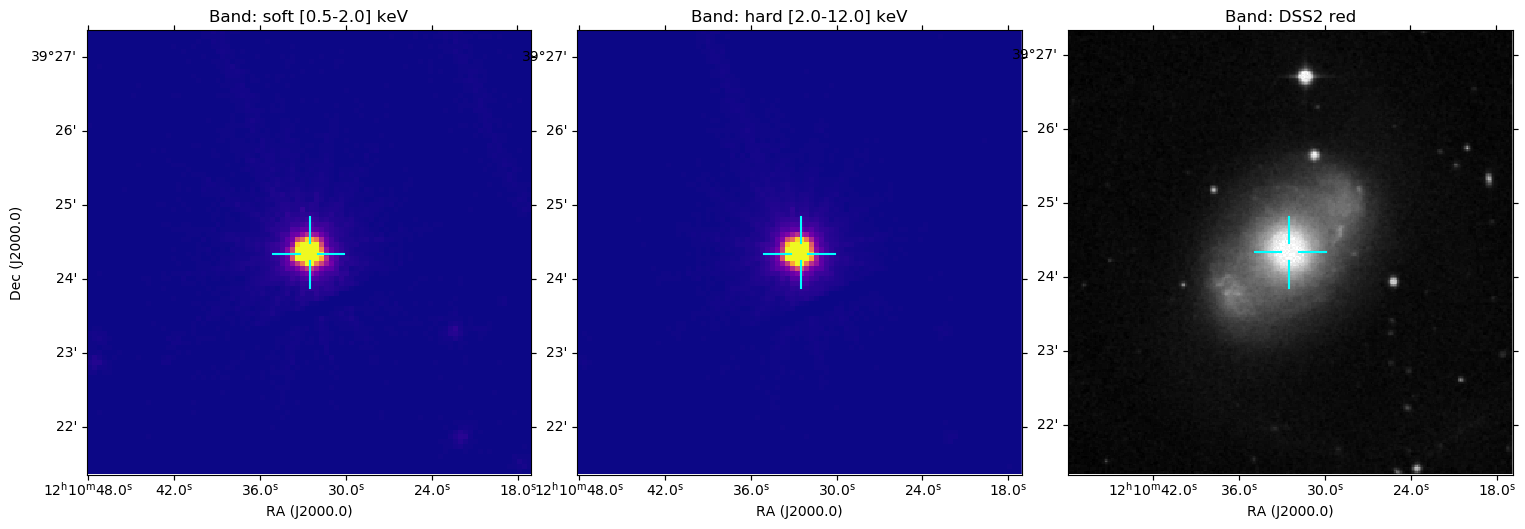

In [112]:
#
# plotting
#
zoomSize = u.Quantity((box,box), u.arcmin)
#
fig = plt.figure(figsize=(15,5),dpi=100)
#
pp = 99.5 #
# labels for the plots
bands = ["soft [0.5-2.0]","hard [2.0-12.0]"]
qbands = ["500_2000","2000_12000"]
#
saveToFits = False
for i,ximage in enumerate([hdu_soft,hdu_hard]):
    wcs = WCS(ximage.header)
    cutout = Cutout2D(ximage.data, c, zoomSize, wcs=wcs,copy=True)
    wcs_cut = cutout.wcs
    ax = fig.add_subplot(1,3,i+1,projection=wcs_cut)
    ax.set_title(f'Band: {bands[i]} keV')
    lon = ax.coords['ra']
    lon.set_axislabel('RA (J2000.0)')
    lon.set_major_formatter('hh:mm:ss.s')
    lat = ax.coords['dec']
    lat.set_major_formatter('dd:mm')
    if (i == 0):
        lat.set_axislabel('Dec (J2000.0)')
    # now normalize the imahe
    norm = ImageNormalize(cutout.data[~np.isnan(cutout.data)], interval=PercentileInterval(pp))
    ax.imshow(cutout.data,norm=norm,cmap=plt.cm.plasma,origin='lower',interpolation='nearest')
    (xc,yc) = wcs_cut.world_to_pixel(c)
    #ax.plot(xc,yc,'+m')
    # plot reticle
    inner, outer = 0.02, 0.08
    ax.axvline(xc,ymin=0.5+inner,ymax=0.5+outer,color='cyan')
    ax.axvline(xc,ymin=0.5-inner,ymax=0.5-outer,color='cyan')
    ax.axhline(yc,xmin=0.5+inner,xmax=0.5+outer,color='cyan')
    ax.axhline(yc,xmin=0.5-inner,xmax=0.5-outer,color='cyan')
    ax.set_autoscale_on(False)
    if (saveToFits):
        xdu = fits.PrimaryHDU(cutout.data)
        xdu.header = ximage.header
        xdu.header.update(cutout.wcs.to_header())
        xdu.writeto(f"{output_dir}/{obsid}_{qbands[i]}_norm.fits",overwrite=True)
    #    
#
# now the DSS2 Red image
pp = 99.9 #
rimage = paths[0][0]
#rimage.data[~np.isnan(rimage.data)]
wcs = WCS(rimage.header)
ax = fig.add_subplot(1,3,3,projection=wcs)
ax.set_title('Band: DSS2 red')
lon = ax.coords['ra']
lon.set_axislabel('RA (J2000.0)')
lon.set_major_formatter('hh:mm:ss.s')
lat = ax.coords['dec']
#lat.set_axislabel('Dec (J2000.0)')
lat.set_major_formatter('dd:mm')
# now normalize the imahe
norm = ImageNormalize(rimage.data[~np.isnan(rimage.data)], interval=PercentileInterval(pp))
ax.imshow(rimage.data,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
#
# plot reticle
(xc,yc) = wcs.world_to_pixel(c)
inner, outer = 0.02, 0.08
ax.axvline(xc,ymin=0.5+inner,ymax=0.5+outer,color='cyan')
ax.axvline(xc,ymin=0.5-inner,ymax=0.5-outer,color='cyan')
ax.axhline(yc,xmin=0.5+inner,xmax=0.5+outer,color='cyan')
ax.axhline(yc,xmin=0.5-inner,xmax=0.5-outer,color='cyan')
#
ax.set_autoscale_on(False)
#
plt.tight_layout(pad=2)
#lgnd = plt.legend(bbox_to_anchor=(0.2, -0.05))
#lgnd.legendHandles[0]._sizes = [50];

In [128]:
print ('X-ray images shape: ',cutout.data.shape,'; Optical image shape:', rimage.data.shape)

X-ray images shape:  (90, 90) ; Optical image shape: (300, 300)


In [43]:
xc-30

118.53015218253972

In [129]:
print (f"Images for {obsid} saved to folder {output_dir}")

Images for 0760530201 saved to folder /Users/ivaltcha/tmp/XMM_data/outputs


In [130]:
print (f'Native pixel scale (arcsec) for EPIC-pn XMM image: {wcs_cut.pixel_scale_matrix[1,1]*3600.0:.1f}\n', 
       f'Native pixel scale (arcsec) for optical DSS2 R image: {wcs.pixel_scale_matrix[1,1]*3600.0:.1f}')

Native pixel scale (arcsec) for EPIC-pn XMM image: 4.0
 Native pixel scale (arcsec) for optical DSS2 R image: 1.2
